In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
import copy
import numpy as np
from models.fno import FNO
from models.pfno import PFNO, PNO_Wrapper
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import DarcyFlowDataset
import cmcrameri
from matplotlib.colors import Normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loader for best predictions

In [2]:
batch_size = 32
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval

data_dir = "../../data/DarcyFlow/processed/"
checkpoint_path = "/home/groups/ai/scholl/pfno/weights/darcy_flow/fno/"

sr_dropout_path = checkpoint_path + "20240913_104527_darcy_flow_fno_sr_dropout/Datetime_20240913_104537_Loss_DarcyFlow_FNO_scoring-rule-dropout_dropout_0.2.pt"
laplace_path = checkpoint_path + "20240915_013209_darcy_flow_fno_laplace/Datetime_20240915_013216_Loss_DarcyFlow_FNO_laplace_dropout_0.02.pt"
#laplace_state_path = checkpoint_path + "20240915_013209_darcy_flow_fno_laplace/Datetime_20240915_013216_Loss_DarcyFlow_FNO_laplace_dropout_0.02_la_state.pt"
dropout_path = checkpoint_path + "20240914_125831_darcy_flow_fno_dropout/Datetime_20240914_125838_Loss_DarcyFlow_FNO_dropout_dropout_0.02.pt"
sr_reparam_path = checkpoint_path + "20240915_141034_darcy_flow_fno_sr_reparam/Datetime_20240915_141041_Loss_DarcyFlow_FNO_scoring-rule-reparam_dropout_0.01.pt"

In [3]:
test_data = DarcyFlowDataset(data_dir, test = True)

# Get domain and range
x,y = test_data.get_coordinates()
L = test_data.get_domain_range()

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

n_test = len(test_loader)

In [7]:
path = "../../results/darcy_flow_test_results/"

dropout_model = FNO(n_modes=(12,12), hidden_channels=32, in_channels = 3,dropout=0.2).to(device)
dropout_cp = torch.load(dropout_path, map_location=torch.device(device))
dropout_model.load_state_dict(dropout_cp)

laplace_model = FNO(n_modes=(12,12), hidden_channels=32, in_channels = 3,dropout=0.02).to(device)
la_model = LA_Wrapper(laplace_model)

la_model.load_state_dict(torch.load(laplace_path))
if isinstance(la_model, LA_Wrapper):
    la_model.load_la_state_dict(torch.load(laplace_path[:-3] + "_la_state.pt"))

pfno_reparam = PFNO(n_modes=(12,12), hidden_channels=32, in_channels = 3,dropout=0.01).to(device)
pfno_cp = torch.load(sr_reparam_path, map_location=torch.device(device))
pfno_reparam.load_state_dict(pfno_cp)

dropout_base = copy.deepcopy(dropout_model)
pfno_dropout = PNO_Wrapper(dropout_base, n_samples = n_samples)

In [8]:
pfno_model = pfno_reparam

# Predictions

In [9]:
samples = np.random.randint(0,n_test,5)

pfno_model.train()
dropout_model.train()
""" Prediction """
pred_pfno = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_pred = pfno_model(a, n_samples = n_samples)
        la_pred = la_model.predictive_samples(a)

        pred_dropout.append( dropout_pred )
        pred_pfno.append( pfno_pred )
        pred_la.append( la_pred )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()

In [10]:
# Plot function should get
# truth, predictions of one sample, names, grid, and save_path

In [11]:
def plot_statistics(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    x,y = grid

    # Get scalings
    pred_array = np.array(preds)
    mse_norm = Normalize(vmin = 0, vmax = np.power(truth - pred_array.mean(axis = -1),2).max())
    std_norm = Normalize(vmin = 0, vmax = pred_array.std(axis = -1).max())
    

    fig, axs = plt.subplots(3,n_models, figsize = (12, 10), subplot_kw=dict(box_aspect=1),
                         sharex=True, sharey=True)
    for m, pred in enumerate(preds):
        truth = truth.squeeze()
        pred = pred.squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(x,y,np.power(truth - pred.mean(axis = -1),2), shading = "nearest", cmap = "cmc.vik", norm = mse_norm)
        im2 = axs[1,m].pcolormesh(x,y,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lajolla", norm = std_norm)
        im3 = axs[2,m].pcolormesh(x,y,coverage, shading = "nearest")
        axs[0,m].set_title(names[m])
    fig.colorbar(im1, ax = axs[0,m])
    fig.colorbar(im2, ax = axs[1,m])
    fig.colorbar(im3, ax = axs[2,m])

    axs[0,0].set_ylabel('Mean squared error')
    axs[1,0].set_ylabel('Standard deviation')
    axs[2,0].set_ylabel('Coverage (95%)')
    fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)
    
    plt.show()

In [12]:
def plot_predictions(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    x,y = grid

    fig, axs = plt.subplots(n_models, 4, figsize = (12, 6), subplot_kw=dict(box_aspect=1),
                         sharex=True, sharey=True)
    for m, pred in enumerate(preds):
        truth = truth.squeeze()
        pred = pred.squeeze()
        axs[m,0].pcolormesh(x,y,truth, shading = "nearest", cmap = "cmc.roma_r")
        axs[m,1].pcolormesh(x,y,pred.mean(axis = -1), shading = "nearest", cmap = "cmc.roma_r")
        axs[m,2].pcolormesh(x,y,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lajolla")
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        axs[m,3].pcolormesh(x,y,coverage, shading = "nearest")
        axs[m,0].set_ylabel(names[m])

    axs[0,0].set_title('Ground truth')
    axs[0,1].set_title('Mean prediction')
    axs[0,2].set_title('Standard deviation')
    axs[0,3].set_title('Coverage (95%)')
    fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300)
    
    plt.show()

# Plot

In [13]:
idx = 0

a,u = test_data.__getitem__(samples[idx])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy()

preds = [pred_dropout[idx], pred_la[idx], pred_pfno[idx]]
names = ['Dropout', 'LA', 'PFNO']

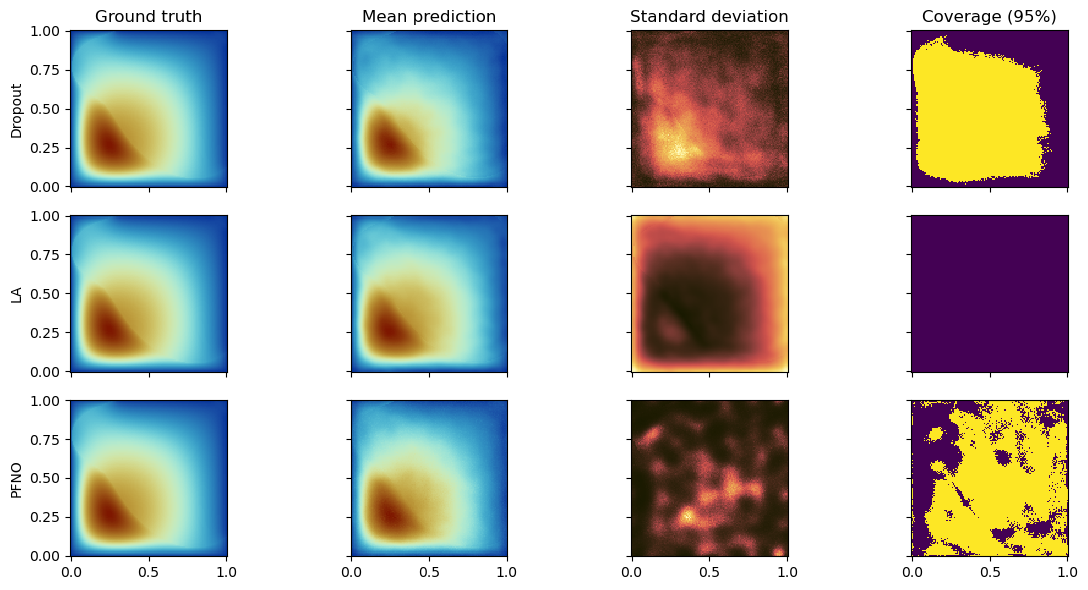

In [14]:
plot_predictions(u, preds, names, (x,y))

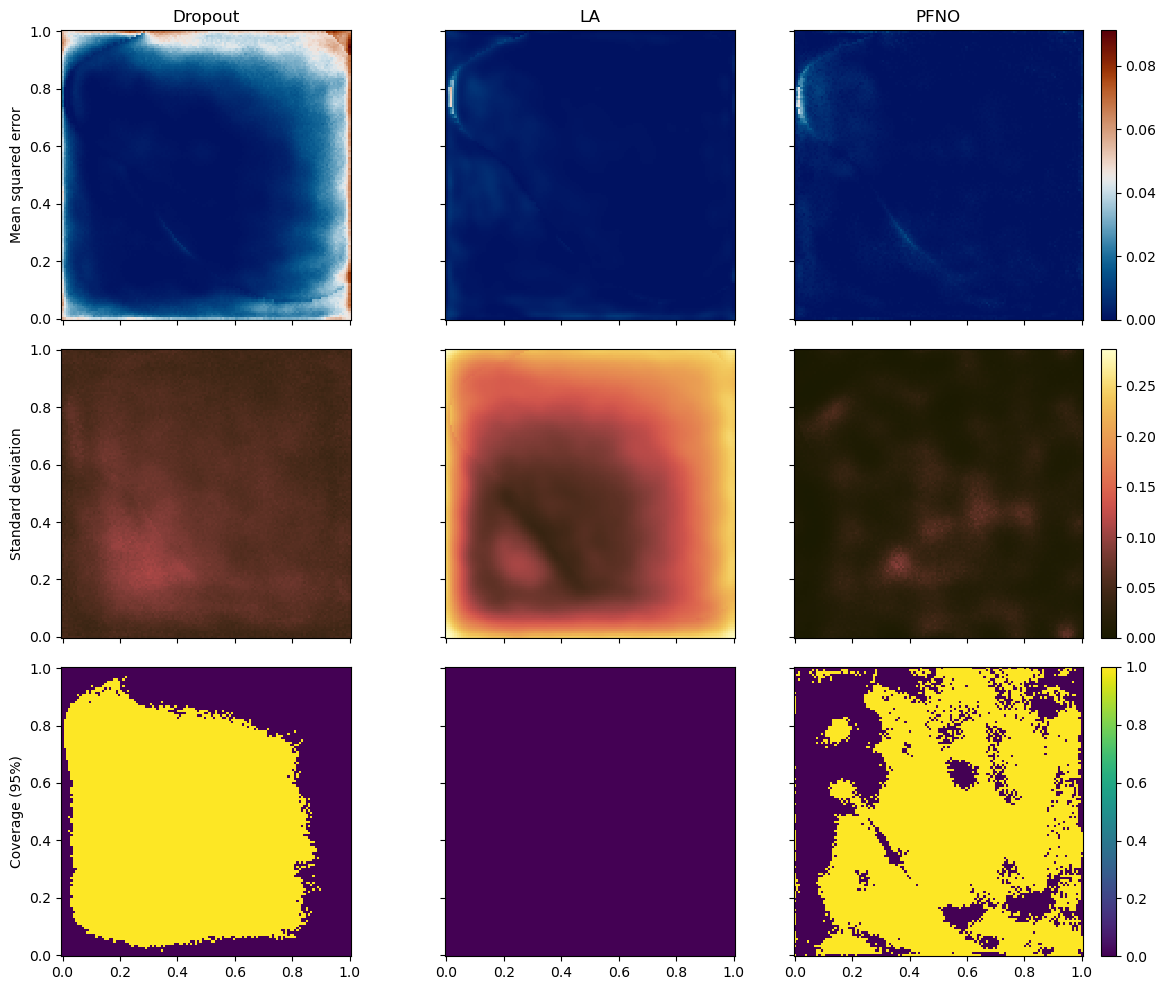

In [15]:
plot_statistics(u, preds, names, (x,y), save_path = None)